## This notebook investigates closed loop metrics of the decoders

We are looking at:
- (a) - Normalised Path Length
- (b) - Throughput    


First the preamble

In [18]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
import pandas as pd
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

# add current path to system PATH 
sys.path.insert(0,'/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaceDataAnalysis')

# Import user defined libraries
import DataExtraction.extractRawData as dataExtractor
from BasicAnalytics import targetAcqusitionPlotting as targetPlotter
from BasicAnalytics import variabilityAnalysis 
from BasicAnalytics import plottingFuncs as pf
from DecoderFunctions import decoderTrainingFunctions as decoder
from DecoderFunctions import closedLoopAnalysisFunctions as decoderCL

blueColor = (11/255, 201/255, 205/255)
redColor = (214/255, 50/255, 48/255)
orangeColor = (242/255, 197/255, 124/255)
poshBlackColor = (114/255, 9/255, 183/255)
from tol_colors import tol_cmap, tol_cset

import numpy as np
import matplotlib.pyplot as plt


# # Using seaborn's style
# plt.style.use('seaborn')
# width = 345

tex_fonts = {

    "text.usetex": True,
    "font.family": "serif",

    "axes.labelsize": 12,
    "font.size": 12,

    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)


In [19]:
os.chdir("/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/BrainMachineInterfaceDataAnalysis")
decoderLabels = ['Body','Partial-body','Left-Hand','Control','Lower-limb','Head-Neck','Random']
# Define save game location
saveGameLocation = "ExperimentRuns" + "/P5_Katsu_28_02" + "/P5_Katsu_28_02__12_00"

First calculate the normalised path length

First we define functionality to calculate the path length as made in Michaelmas

In [20]:
# function to plot trajectories
def plotTrajectoriesClosedLoop(returnDict,k = 3,savepath=None, failed = False, plot = False):
    """

    Args:

    failed: true if plotting failed acquisitions
    """
    individualMovements = decoderCL.readIndividualTargetMovements(returnDict)
    #print("First let's plot the trajectories")
    if k is not None and k.__class__ != list:
        
        cursorPosData = [individualMovements['cursorPosData'][0:int(2*k):2]] #  trajectories
    
    elif k.__class__ == list:

         cursorPosData = [individualMovements['cursorPosData'][i] for i in k]
    else:
        cursorPosData = individualMovements['cursorPosData'][0:-1:3] #  trajectories

    if plot:
        decoderCL.plotVar(cursorPosData,list_ = True,invertY=True)

    if failed:
        targetLocations = [returnDict['targetBoxLocs'][i] for i in k]
        if plot:
            decoderCL.plotVar(targetLocations, list_ = True, invertY = True, points = True)
    if plot:
        ax1 = plt.gca()  # Get current axes


    # Remove top and right spines for the first plot
    if plot:
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        # Reduce x and y ticks and increase font
        plt.xticks([0,1], fontsize = 20)
        plt.yticks([0,1],fontsize = 20)
        plt.xlabel("Normalised X position", fontsize = 20, fontweight = "bold")
        plt.ylabel("Normalised Y position",fontsize = 20,fontweight = "bold")
        plt.xlim(0,1)
        plt.ylim(0,1)
    if savepath is not None:
        pass
        plt.savefig(savepath)
    if plot:
        plt.show()


    #print("Now let's plot the evolution of normalised aquisition time")
    MTs,IDs,IPs,pathLengths = calcNormalisedAcquisitionTimes_jpy(individualMovements,k, plot = plot)

    return MTs,IDs,IPs,pathLengths

def calcHumanPerformance_jpy(totalTime,reactionTime,D,W):
    """uses Fitts law to calculate human performance"""
    MT = totalTime
    ID = np.log2((2*D)/W)
    IP = ID / (MT/1000)
    return MT,ID,IP

def calcDist(startPos,endPos):
    ranges = [1100 + 800,800 + 225]
    return np.sqrt(np.sum([ (ranges[i] * (endPos[i] - startPos[i])) ** 2 for i in range(len(startPos))]))

def calcNormalisedAcquisitionTimes_jpy(processedDataDict,k,start = 0, end = -1,reactionTime = 300, plot = False):
    """
    This function takes in data giving the start and location for each acquisition and 
    """
    cursorPosData = [processedDataDict['cursorPosData'][i] for i in k]
    timestamps =  [processedDataDict['timestamps'][i] for i in k]
    IPs = []
    pathLengths = []
    MTs = []
    IDs = []

    for idx,var in enumerate(cursorPosData):
        var = var.transpose()
        # Calculate the distance to each target from the starting point
        startPos = (var[0,0],var[0,1])
        endPos = (var[-1,0],var[-1,1])
        idxes = len(var[:,0])
        distToTarget = np.sqrt(np.sum([ (endPos[i] - startPos[i]) ** 2 for i in range(len(startPos))]))
        
        # Calculate distance unnormalised distance for fitts law
        ranges = [1100+800,800 + 225]
        D = np.sqrt(np.sum([ (ranges[i] * (endPos[i] - startPos[i])) ** 2 for i in range(len(startPos))]))
        if D == 0:
            continue
        pathlength =sum([calcDist( (var[i,0],var[i,1]), (var[i+1,0],var[i+1,1])  ) for i in range(0,idxes-2)]) / D
        #print(pathlength)
        pathLengths.append(pathlength)
        # Calculate the time difference  
        timeStart = timestamps[idx][0]
        timeEnd = timestamps[idx][-1]




        # the raw acquisition time before being normalised for distance and reaction time
        totalTime = timeEnd - timeStart
        cursorWidth = 60
        MT,ID,IP = calcHumanPerformance_jpy(totalTime,reactionTime,D,W=60)
        IPs.append(IP)
        MTs.append(MT)
        IDs.append(ID)
        

    if plot:
        plt.plot(IPs, label = "Index of Performances")
        plt.show()
    return MTs,IDs,IPs,pathLengths
    

In [21]:
#] IPs = plotTraj(modelA_dict, k=20,i=i)
# print(IPs)

def plotDecoderTrajectories(gameSavePath,decoderType,returnDict,choices = None, plot = False):

    """
    This function returns index of performances and path lengths for successful and failed target acqusitions
    """
    #returnDict = decoderCL.processTrialData(gameSavePath+ "_usingDecoder" + decoderType + ".npz",None,DOFOffset=0.1,returnAsDict=True,ignoreCalibration= True)

    # plt.plot(returnDict['cursorPos'][:,0],returnDict['cursorPos'][:,1] )
    #plt.show()

    # Submit all target acquisitions to k
    idxes = [i for i in range(len(returnDict['successfulAcquires'])-1) if returnDict['successfulAcquires'][i] == True ]

    #print("Successful targets acquired: ", idxes)
    if choices is not None:
        options = min(choices, len(idxes))
        idxes = list(np.random.choice(idxes, options, replace=False))
    # Plot all successful acquisitions 
    successfulMTs,successfulIDs,successfulIPs,successfulpathLengths = plotTrajectoriesClosedLoop(returnDict,k = idxes,savepath=None , plot = plot)
    



    # Submit all failed target acquisitions to k
    idxesFailed = [i for i in range(len(returnDict['successfulAcquires'] ) - 1) if returnDict['successfulAcquires'][i] == False]
    #print("Targets unsuccessfully acquired",idxesFailed)
    if choices is not None:
        options = min(choices, len(idxesFailed))
        idxesFailed = list(np.random.choice(idxesFailed, options, replace=False))
    

    # Plot all failed acquisitions 
    failedMTs,failedIDs,failedIPs,failedpathLengths = plotTrajectoriesClosedLoop(returnDict,k = idxesFailed,savepath=None,failed = True)

    normalisedPathLengthsSuccess = np.concatenate([successfulpathLengths,failedpathLengths])
    individualThroughputsSucesss = successfulIPs
    movementTimes = successfulMTs
    IndexesOfDifficulties = successfulIDs
    proportionFailed = len(failedMTs) / (len(successfulMTs) + len(failedMTs))

    return {
        "normPathLengths": normalisedPathLengthsSuccess,
        "Individual IPs": individualThroughputsSucesss,
        "MT": movementTimes,
        "ID": IndexesOfDifficulties,
        "proportionFailed": proportionFailed,
        "Successes": len(successfulMTs),
        "Fails": len(failedMTs)
    }


In [22]:
#print(saveGameLocation)
returnDict = decoderCL.processTrialData(saveGameLocation+"_usingDecoderK.npz",None,DOFOffset=0.1,returnAsDict=True,ignoreCalibration= True)
closedLoopMetricDict= plotDecoderTrajectories(saveGameLocation, decoderType = "K", returnDict = returnDict,choices=None)


TargetReachTimes [ 26171.  34977.  43802.  52619.  61427.  70243.  79061.  87876.  96689.
 105498. 114312. 120004.]
GoCueTimes [ 16178.  24985.  33804.  42619.  51430.  60245.  69062.  77881.  86689.
  95504. 104312. 113124.]
successfulAcquires [False, False, False, False, False, False, False, False, False, False, False, False]
IPs []
IDs []


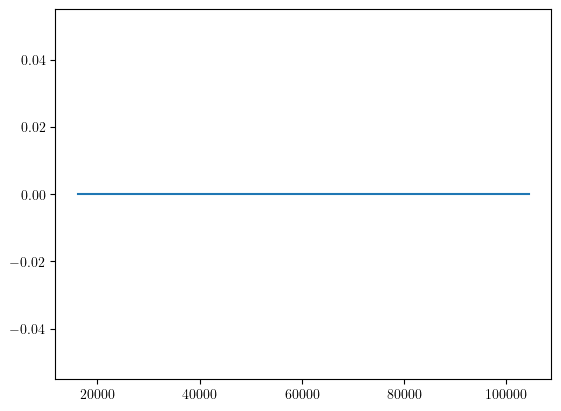

In [23]:
print("TargetReachTimes",returnDict['timestamps'][returnDict['targetReached']])
print("GoCueTimes",returnDict['timestamps'][returnDict['goCues']])
print("successfulAcquires",returnDict['successfulAcquires'])
print("IPs", closedLoopMetricDict['Individual IPs'])
print("IDs", closedLoopMetricDict['ID'])

allIPs = []
ipIdx = 0
for i in range(len(returnDict['goCues'])-1):
    if returnDict['successfulAcquires'][i] == True:
        allIPs.append(min(10,closedLoopMetricDict['Individual IPs'][ipIdx]))
        ipIdx += 1
    else:
        allIPs.append(0)

#allIPs = smooth_list(allIPs,4)
plt.plot(returnDict['timestamps'][returnDict['goCues']][:-1],allIPs)

In [24]:
import numpy as np

def create_2d_array_with_values(locations, values, step):
    """
    Create a 2D array where the first column is a sequence of numbers with a given step size
    and the second column contains zeros except at specified locations which will have corresponding values.
    
    Parameters:
    - locations: List of int, specifying the locations where values should be set.
    - values: List of float, specifying the values to set at the corresponding locations.
    - step: int, specifying the step size for the sequence in the first column.
    
    Returns:
    - result: 2D numpy array with the sequence in the first column and specified values in the second column.
    """
    max_value = 120000
    sequence = np.arange(1, max_value + 1, step)
    second_column = np.zeros_like(sequence, dtype=float)
    
    for loc, val in zip(locations, values):
        # Find the closest index in the sequence to the current location
        closest_idx = (np.abs(sequence - loc)).argmin()
        second_column[closest_idx] = val
    
    result = np.column_stack((sequence, second_column))
    return result

def gaussian_smoothing(signal, kernel_size, sigma):
    """
    Apply Gaussian smoothing to a 1D signal.
    
    Parameters:
    - signal: 1D numpy array representing the input signal.
    - kernel_size: int, size of the Gaussian kernel (must be odd).
    - sigma: float, standard deviation of the Gaussian kernel.
    
    Returns:
    - smoothed_signal: 1D numpy array representing the smoothed signal.
    """
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be odd.")
    
    # Generate Gaussian kernel
    kernel_range = np.arange(-(kernel_size // 2), (kernel_size // 2) + 1)
    kernel = np.exp(-0.5 * (kernel_range / sigma) ** 2)
    kernel = kernel / np.sum(kernel)  # Normalize the kernel
    
    # Apply Gaussian smoothing
    smoothed_signal = np.convolve(signal, kernel, mode='same')

    halfKernel = (kernel_size - 1) // 2
    #smoothed_signal[-halfKernel:] = smoothed_signal[-halfKernel - 1]
    # smoothed_signal[-halfKernel:] = smoothed_signal[-halfKernel - 1]

    return smoothed_signal

# Example usage
if __name__ == "__main__":
    locations = [1243, 1942, 29444, 50182]
    values = [0, 0, 1.2, 1.5]
    locations = returnDict['timestamps'][returnDict['goCues']][:-1]
    values = allIPs
    step = 50 # Adjust step size as needed
    kernel_size = 401# Should be odd
    sigma = 75 # Standard deviation for Gaussian kernel
    
    # Create the 2D array with specified values at given locations
    result_array = create_2d_array_with_values(locations, values, step)
    
    # Apply Gaussian smoothing to the second column
    smoothed_column = gaussian_smoothing(result_array[:, 1], kernel_size, sigma)
    
    # Combine the sequence and the smoothed column into a 2D array
    smoothed_array = np.column_stack((result_array[:, 0], smoothed_column))
    
    # # Print the result
    # print("Original 2D Array:")
    # print(result_array)
    # print("\nSmoothed 2D Array:")
    # print(smoothed_array)

#plt.plot(smoothed_array[:,0],smoothed_array[:,1])

In [25]:
# Retrieve identifiers for each participant
decoderNum2Letter = {0: 'E', 1: 'F', 2: 'G', 
                3:'H', 4: 'I', 5: 'J', 6: 'K'
}

# Define which participants used range control
rangeControl = [1,1,1,0,0,0,1,1,0,0,0]
usedRangeControl = [0,1,2,6,7]
noRangeControl = [3,4,5,8,9,10]

# Get arbitrary training files
participantIdentifiers = dataExtractor.extractSpecificParticipantFiles(trialType = "_training1")
noParticipants = len(participantIdentifiers)
noDecoders = 7

# Remove training part off each file
for i in range(len(participantIdentifiers)):
    participantIdentifiers[i] = participantIdentifiers[i].replace("_training1", "")



In [26]:
avgPathLengths = np.zeros((noDecoders, noParticipants))
avgIPs = np.zeros((noDecoders, noParticipants))
propFails = np.zeros((noDecoders, noParticipants))
sigma = 120
kernel_size = 801

MTsAll = np.arange(1, noDecoders * noParticipants + 1).reshape(noDecoders, noParticipants)
MTsAll = MTsAll.tolist()

IDsAll = np.arange(1, noDecoders * noParticipants + 1).reshape(noDecoders, noParticipants)
IDsAll = IDsAll.tolist()

# To be used in time vs IP plot
IPAllTrials = np.arange(1, noDecoders * noParticipants + 1).reshape(noDecoders, noParticipants)
IPAllTrials = IPAllTrials.tolist()

performanceMetricAllTrials = np.zeros((noDecoders, noParticipants,2400,2))
performanceMetricAllTrialsNotNormalised = np.zeros((noDecoders, noParticipants,2400,2))

targetReachTimesAllTrials = np.arange(1, noDecoders * noParticipants + 1).reshape(noDecoders, noParticipants)
targetReachTimesAllTrials = targetReachTimesAllTrials.tolist()

for decoderIdx in range(noDecoders):
    for participantIdx in range(noParticipants):
        
        
        # Define participant and decoder data
        decoderLetter = decoderNum2Letter[decoderIdx]
        participantIdentifier = participantIdentifiers[participantIdx]

        # if participantIdentifier == "ExperimentRuns/P6_Tejas_28_02/P6_Tejas_28_02__12_00" and decoderLetter == 'F':
        #     print("debug")

        # Fetch closed loop data
        returnDict = decoderCL.processTrialData(participantIdentifier + "_usingDecoder" + decoderLetter + ".npz",None,DOFOffset=0.1,returnAsDict=True,ignoreCalibration= True)
        closedLoopMetricDict= plotDecoderTrajectories(participantIdentifier, decoderType = decoderLetter, returnDict = returnDict,choices=None)

        # Fetch IP Data for time vs IP plot
        allIPs = []
        ipIdx = 0
        
        for i in range(len(returnDict['goCues'])-1):
            if returnDict['successfulAcquires'][i] == True:
                try:
                    allIPs.append(min(10,closedLoopMetricDict['Individual IPs'][ipIdx]))
                except:
                    print(decoderLetter,participantIdentifier)
                ipIdx += 1
            else:
                allIPs.append(0.1)


        # Create the 2D array with specified values at given locations
        result_array = create_2d_array_with_values(returnDict['timestamps'][returnDict['goCues']][:-1], allIPs, step)
        performanceMetricAllTrialsNotNormalised[decoderIdx,participantIdx] = result_array
        # Apply Gaussian smoothing to the second column
        smoothed_column = gaussian_smoothing(result_array[:, 1], kernel_size, sigma)
        
        # Combine the sequence and the smoothed column into a 2D array N x 2
        performanceMetricAllTrials[decoderIdx,participantIdx]  = np.column_stack((result_array[:, 0], smoothed_column))

        # Store data 
        avgPathLengths[decoderIdx,participantIdx] = np.average(closedLoopMetricDict['normPathLengths'])
        avgIPs[decoderIdx,participantIdx] = np.sum(closedLoopMetricDict['Individual IPs'])/(closedLoopMetricDict['Successes'] +closedLoopMetricDict['Fails'] )
        
        
        propFails[decoderIdx,participantIdx] = closedLoopMetricDict['proportionFailed']

        MTsAll[decoderIdx][participantIdx] = closedLoopMetricDict['MT']
        IDsAll[decoderIdx][participantIdx] = closedLoopMetricDict['ID']


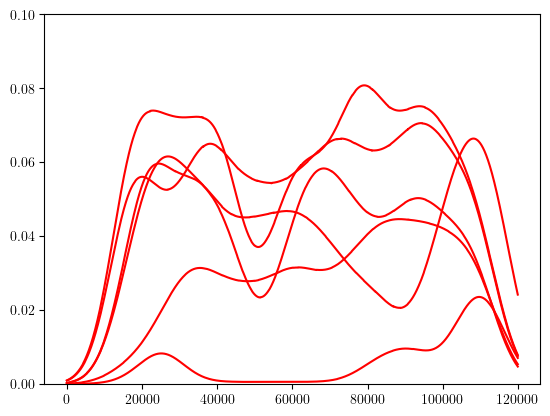

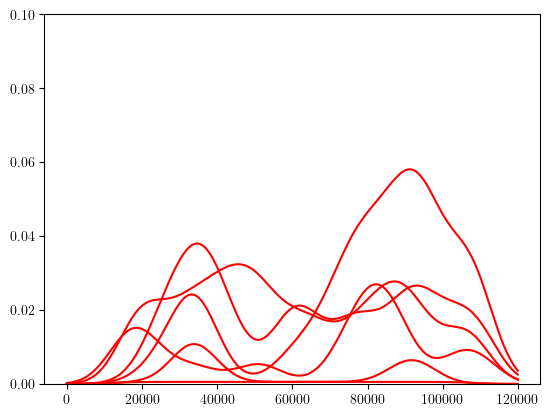

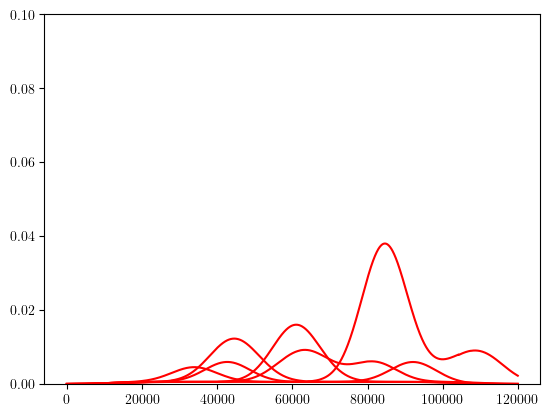

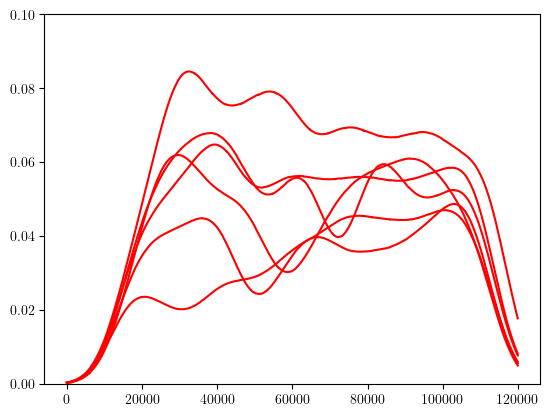

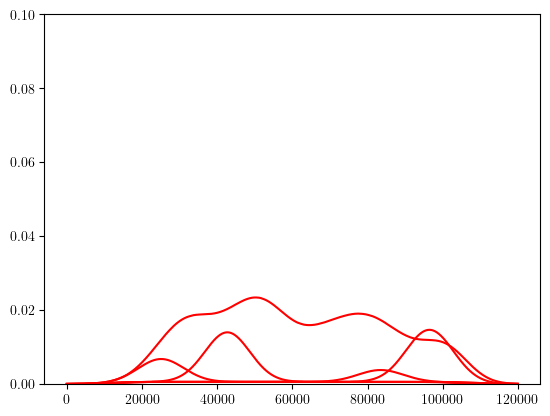

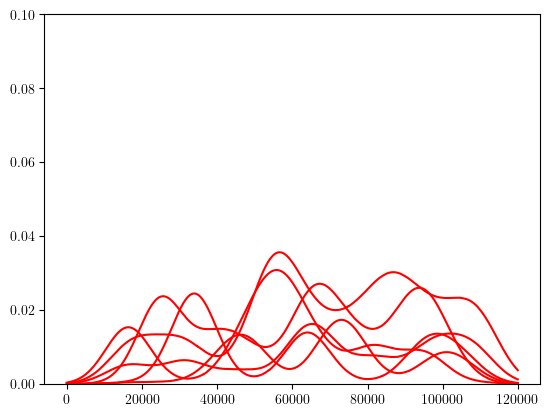

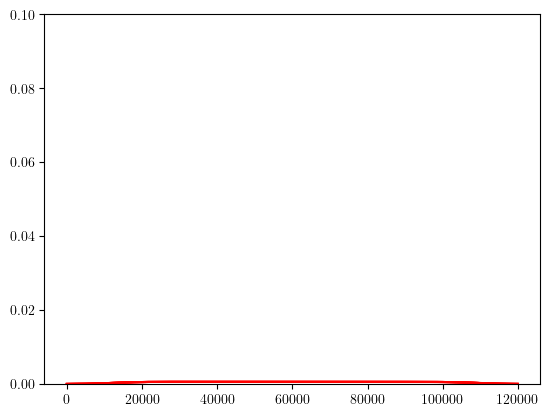

In [27]:
for j in range(noDecoders):
    for i in noRangeControl:
        plt.plot(performanceMetricAllTrials[j,i][:,0],performanceMetricAllTrials[j,i][:,1], color = 'red')
    
    # for i in usedRangeControl:
    #     plt.plot(performanceMetricAllTrials[j,i][:-200,0],performanceMetricAllTrials[j,i][:-200,1], color = 'blue')
    plt.ylim(0,0.1)
    plt.show()

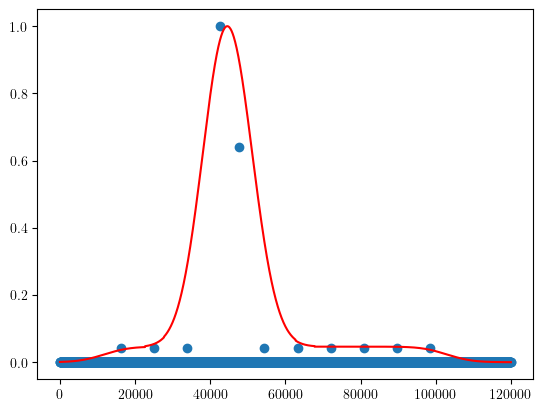

In [28]:

decoder = 2 # 2 is G
k = np.random.choice(noRangeControl)
maxVal = np.max(performanceMetricAllTrials[decoder,k][:,1])
plt.plot(performanceMetricAllTrials[decoder,k][:,0],performanceMetricAllTrials[decoder,k][:,1]/maxVal, color = 'red')

maxVal = np.max(performanceMetricAllTrialsNotNormalised[decoder,k][:,1])

plt.scatter(performanceMetricAllTrialsNotNormalised[decoder,k][:,0],performanceMetricAllTrialsNotNormalised[decoder,k][:,1]/maxVal)    


Display normalised path length

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def createDoubleErrorBarPlot(arr1, arr2, xLabel, yLabel, xTicks, xTickLabels, ax=None, barColor='skyblue', offsetLabel=False, plotTopErrorOnly=True, plotSEM=True, rot=45,
                             align='center', width=0.4, colorTicks=True, ha='right'):
    """Create a Bar plot with error bars contrasting a change in arr 1 and arr 2

    Args:
        arr1: a 2D array of shape [N1,P] showing N number datapoints for P parameters (range controlled)
        arr2: a 2D array of shape [N2,P] showing N number datapoints for P parameters (non range controlled)
        xLabel: label (str) of x axes
        yLabel: label (str) of y axes
        xTicks: values of ticks to plot (1d numeric arr)
        xTickLabels: labels to associate each tick to 
        ax: axes to plot on, can be None
        barColor: color of bar, any format that matplotlib can handle
    """
    arr1 = np.nan_to_num(arr1, nan=10000)
    arr2 = np.nan_to_num(arr2, nan=10000)
    # Create a DataFrame with random data, parameters are the columns, datapoints are the rows
    data1 = pd.DataFrame(arr1, columns=[f'Variable {i+1}' for i in range(arr1.shape[1])])
    data2 = pd.DataFrame(arr2, columns=[f'Variable {i+1}' for i in range(arr2.shape[1])])

    # Calculate mean and standard deviation for each variable
    means1 = data1.mean(axis=0)
    means2 = data2.mean(axis=0)

    if plotSEM:
        std_devs1 = data1.std(axis=0) / np.sqrt(arr1.shape[0])
        std_devs2 = data2.std(axis=0) / np.sqrt(arr2.shape[0])
    else:
        std_devs1 = data1.std(axis=0)
        std_devs2 = data2.std(axis=0)

    # Create a bar plot
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    indices = np.arange(len(means1))

    # Plotting bars for arr1 and arr2 side by side
    bar_width = width / 2

    if plotTopErrorOnly:
        # reformat errors to be 2 x N
        bottomErrors1 = np.zeros(std_devs1.shape[0])
        bottomErrors2 = np.zeros(std_devs2.shape[0])

        yErrors1 = np.concatenate([bottomErrors1.reshape(-1, 1), np.asarray(std_devs1).reshape(-1, 1)], axis=1).T
        yErrors2 = np.concatenate([bottomErrors2.reshape(-1, 1), np.asarray(std_devs2).reshape(-1, 1)], axis=1).T

        ax.bar([0],[0], color='k', alpha=0.3, width=bar_width, label='Normal')
        ax.bar([0],[0], color='k', alpha=1, width=bar_width, label='Adaptive Decoder')
        

        ax.bar(indices - bar_width / 2, means2, yerr=yErrors2, capsize=0, ecolor=barColor, color=barColor, alpha=0.3, width=bar_width)
        ax.bar(indices + bar_width / 2, means1, yerr=yErrors1, capsize=0, ecolor=barColor, color=barColor, alpha=1, width=bar_width)
        
    else:
        ax.bar(indices - bar_width / 2, means1, yerr=std_devs1, capsize=5, color=barColor, alpha=0.3, width=bar_width, label='Arr1')
        ax.bar(indices + bar_width / 2, means2, yerr=std_devs2, capsize=5, color=barColor, alpha=1, width=bar_width, label='Arr2')

    if offsetLabel:
        ax.set_xlabel(xLabel, labelpad=60)
    else:
        ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)

    if ha:
        ax.set_xticks(indices+0.4)
        ax.set_xticklabels(xTickLabels, rotation=rot, ha=ha)  # Rotate x-axis labels for better visibility
    else:
        ax.set_xticks(indices+0.4)
        ax.set_xticklabels(xTickLabels, rotation=rot)

    if colorTicks:
        for xtick, color in zip(ax.get_xticklabels(), barColor):
            xtick.set_color(color)
    


    
    ax.legend()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']


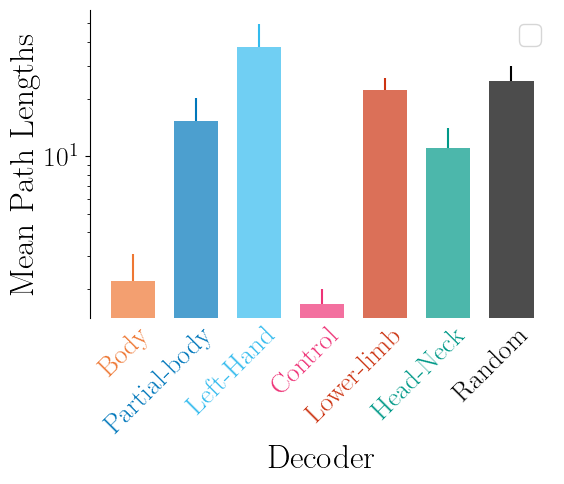

['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']


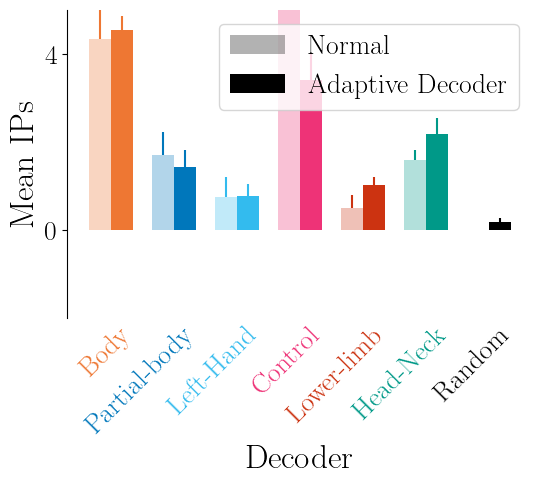

['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']


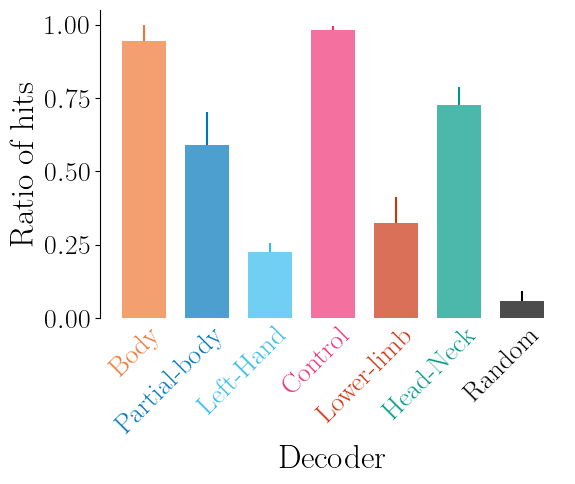

In [57]:
# Now plot bar plot with errors bars need to check the code below




# Now plot bar plot with errors bars need to check the code below

# Define necessary variables


fig = plt.figure(figsize = (6,4))
ax = plt.gca()

def plotPathLengths(ax,rangeControl = None):

    x =  range(0, 7)


    cmap = tol_cset('vibrant')
    colors = list(cmap[0:7])
    print(colors)
    colors[6] = '#000000'
    if rangeControl:
        createDoubleErrorBarPlot(avgPathLengths[:7,usedRangeControl].T,avgPathLengths[:7,noRangeControl].T,xLabel = "Decoder", yLabel = "Mean Path Lengths",
        xTicks = x, xTickLabels = decoderLabels, ax = ax, barColor = colors,rot = 45,width = 0.7,align='edge',colorTicks = True)
    else:
        pf.createErrorBarPlot(avgPathLengths[:7,:].T,xLabel = "Decoder", yLabel = "Mean Path Lengths",
        xTicks = x, xTickLabels = decoderLabels, ax = ax, barColor = colors,rot = 45,width = -0.7,align='edge',colorTicks = True)
    

    ax.legend()
    pf.defaultPlottingConfiguration(ax,maxYTicks = 4,removeXTick=True,legendSize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='heavy')
    #ax.set_yticks([0,1],labels = [0,1]) 
    plt.yscale('log')
    #plt.ylim(-2,2)

plotPathLengths(ax)
plt.show()
# Define necessary variables



def plotIPs(ax,rangeControl = None):

    x =  range(0, 7)


    cmap = tol_cset('vibrant')
    colors = list(cmap[0:7])
    print(colors)
    colors[6] = '#000000'

    if rangeControl:
        createDoubleErrorBarPlot(avgIPs[:7,usedRangeControl].T,avgIPs[:7,noRangeControl].T,xLabel = "Decoder", yLabel = "Mean IPs",
        xTicks = x, xTickLabels = decoderLabels, ax = ax, barColor = colors,rot = 45,width = 0.7,align='edge',colorTicks = True)
    else:
        pf.createErrorBarPlot(avgIPs[:7,].T,xLabel = "Decoder", yLabel = "Mean IPs",
        xTicks = x, xTickLabels = decoderLabels, ax = ax, barColor = colors,rot = 45,width = -0.7,align='edge',colorTicks = True)

    pf.defaultPlottingConfiguration(ax,maxYTicks = 2,removeXTick=True,legendSize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='heavy')
    #plt.yscale('log')
    plt.ylim(-2,5)
fig = plt.figure(figsize = (6,4))
ax = plt.gca()
plotIPs(ax,rangeControl=True)
plt.show()

# Define necessary variables
x =  range(0, 4)


cmap = tol_cset('bright')
colors = cmap[0:4]

fig = plt.figure(figsize = (6,4))
ax = plt.gca()

def plotHitRatio(ax, rangeControl = False):

    x =  range(0, 7)


    cmap = tol_cset('vibrant')
    colors = list(cmap[0:7])
    print(colors)
    colors[6] = '#000000'
    # propFails[6,noRangeControl] = 0
    if rangeControl:
        createDoubleErrorBarPlot(1 - propFails[:7,usedRangeControl].T,1 - propFails[:7,noRangeControl].T,xLabel = "Decoder", yLabel = "Ratio of hits",
        xTicks = x, xTickLabels = decoderLabels, ax = ax, barColor = colors,rot = 45,width = 0.7,align='edge',colorTicks = True)
    else:
        pf.createErrorBarPlot(1 - propFails[:7,:].T,xLabel = "Decoder", yLabel = "Ratio of hits",
        xTicks = x, xTickLabels = decoderLabels, ax = ax, barColor = colors,rot = 45,width = -0.7,align='edge',colorTicks = True)

    pf.defaultPlottingConfiguration(ax,maxYTicks = 2,removeXTick=True,legendSize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='heavy')
    plt.yscale('linear')
    #plt.ylim(-2,2)
plotHitRatio(ax)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']
['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']
['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']


/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10739/3466394105.py:64: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-2,5)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10739/2744875749.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("2.2-DecoderClosedLoopPerformance.pdf",bbox_inches = "tight")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10739/2744875749.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("2.2-DecoderClosedLoopPerformance.pdf",bbox_inches = "tight")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10739/2744875749.py:18: MatplotlibDeprecationWarning: savefig() got

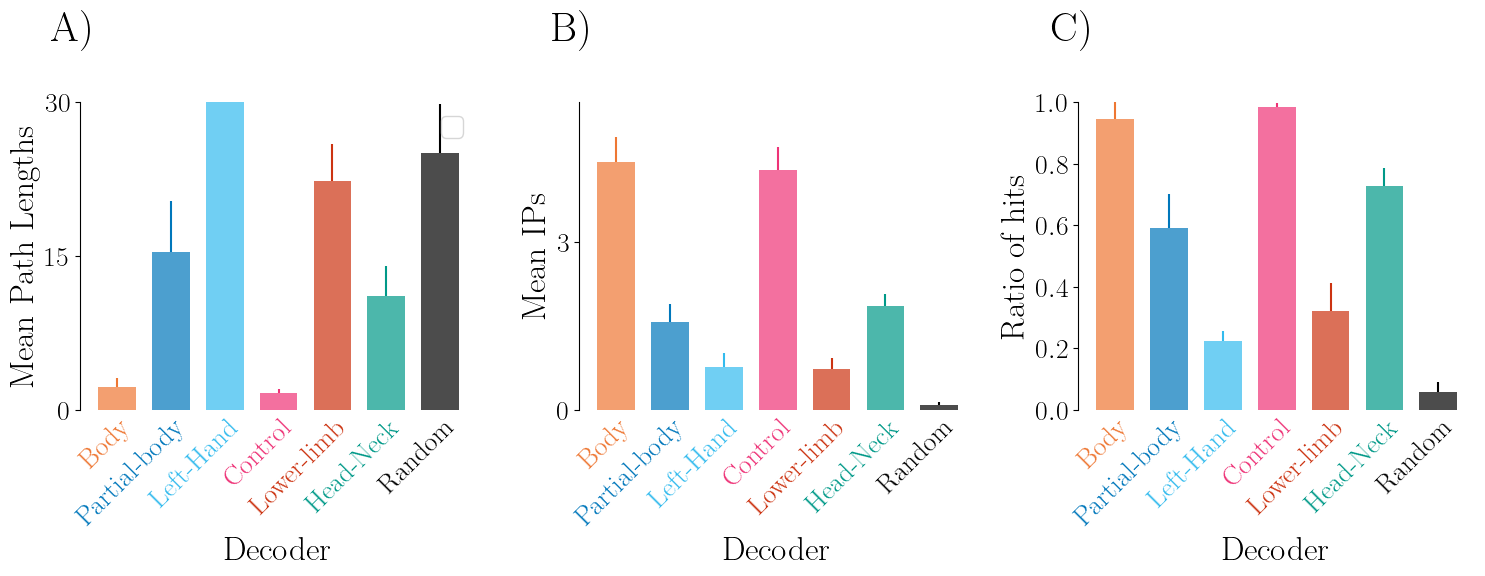

In [43]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (18,4))
gs = GridSpec(1,5,figure=fig,width_ratios=[0.33,0.005,0.33,0.005,0.33])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[0, 4])

plotPathLengths(ax0)
ax0.text(-1.2, 30*1.3, 'A)', ha='center', va='top', fontsize=30, fontweight = "bold")
ax0.set_ylim(0,30)
plotIPs(ax1)
ax1.text(-1.15, 5.5 * 1.3, 'B)', ha='center', va='top', fontsize=30, fontweight = "bold")
ax1.set_ylim(0,5.5)
plotHitRatio(ax2)
ax2.set_ylim(0,1)
ax2.text(-1.15, 1.3, 'C)', ha='center', va='top', fontsize=30, fontweight = "bold")
plt.savefig("2.2-DecoderClosedLoopPerformance.pdf",bbox_inches = "tight")




['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']
['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']
['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']


/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10739/4054908614.py:64: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-2,5)
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10739/2750111219.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("3-RangeControlComparison.pdf",bbox_inches = "tight")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10739/2750111219.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("3-RangeControlComparison.pdf",bbox_inches = "tight")
/var/folders/bd/_1l03dkj5l11l_q7br4tgzh40000gn/T/ipykernel_10739/2750111219.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyw

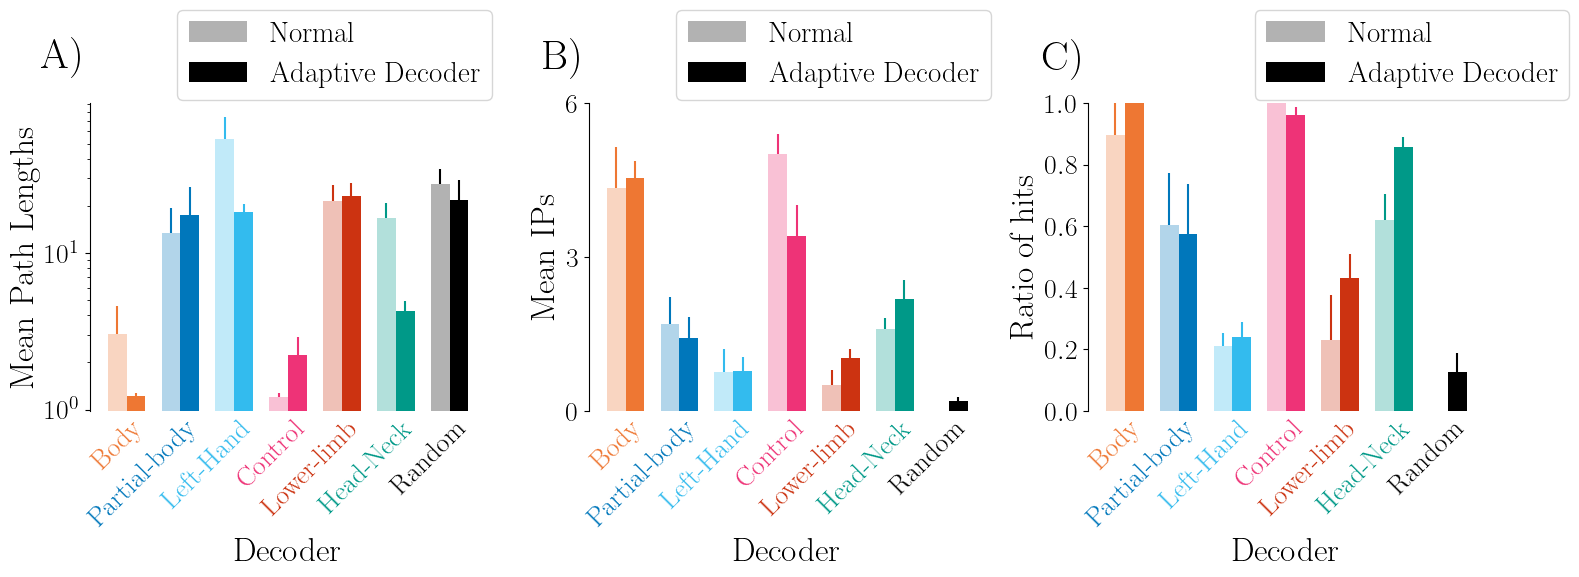

In [59]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (18,4))
gs = GridSpec(1,5,figure=fig,width_ratios=[0.33,0.005,0.33,0.005,0.33])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[0, 4])

plotPathLengths(ax0,rangeControl = True)
ax0.text(-1.2, 187.8*1.3, 'A)', ha='center', va='top', fontsize=30, fontweight = "bold")
#ax0.set_ylim(0,1)
ax0.set_yscale('log')
plotIPs(ax1, rangeControl = True)
ax1.text(-1.15, 5.6 * 1.3, 'B)', ha='center', va='top', fontsize=30, fontweight = "bold")
ax1.set_ylim(0,6)
plotHitRatio(ax2, rangeControl = True)
ax2.legend(loc = 'upper right', fontsize = 21,bbox_to_anchor=(1.25, 1.35))
ax1.legend(loc = 'upper right', fontsize = 21,bbox_to_anchor=(1.05, 1.35))
ax0.legend(loc = 'upper right', fontsize = 21,bbox_to_anchor=(1.05, 1.35))
ax2.set_ylim(0,1)
ax2.text(-1.15, 1.21, 'C)', ha='center', va='top', fontsize=30, fontweight = "bold")
plt.savefig("3-RangeControlComparison.pdf",bbox_inches = "tight")



Slope: 804.466483698171
Intercept: -2399.704004763425


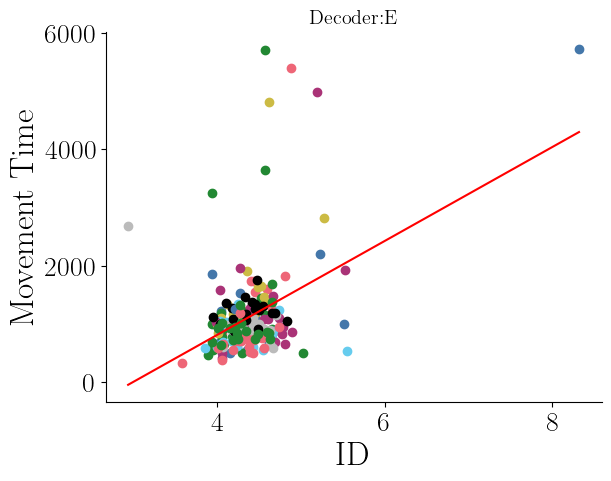

Slope: 627.0205470400617
Intercept: -664.4726497710212


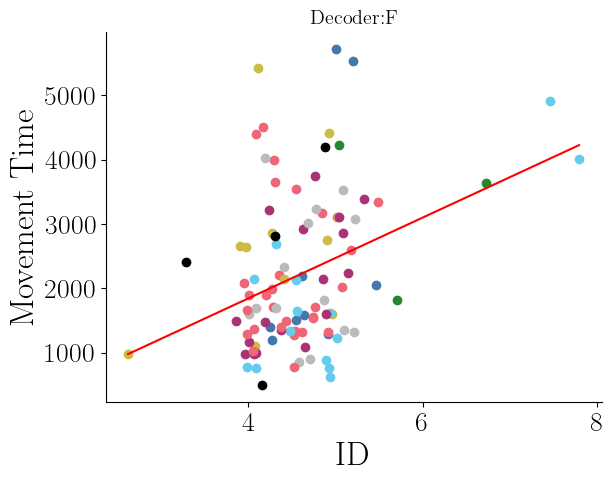

Slope: 252.30503370266385
Intercept: 1564.3621173987808


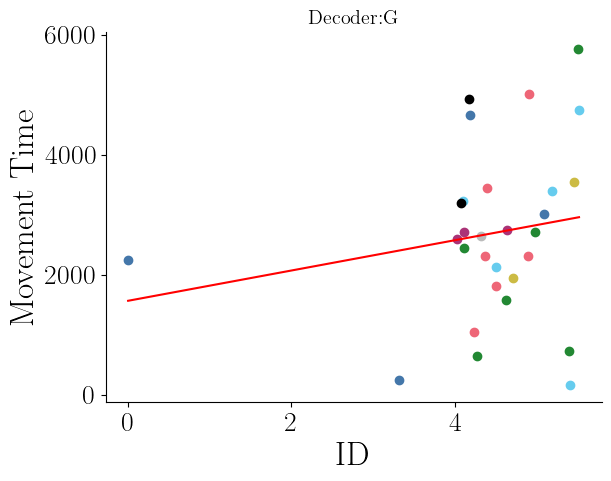

Slope: 406.94954733259425
Intercept: -563.9080287065149


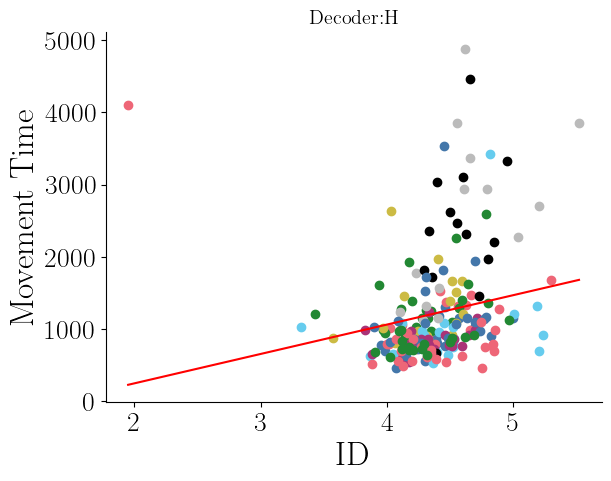

Slope: 162.4987538208723
Intercept: 2026.273228307353


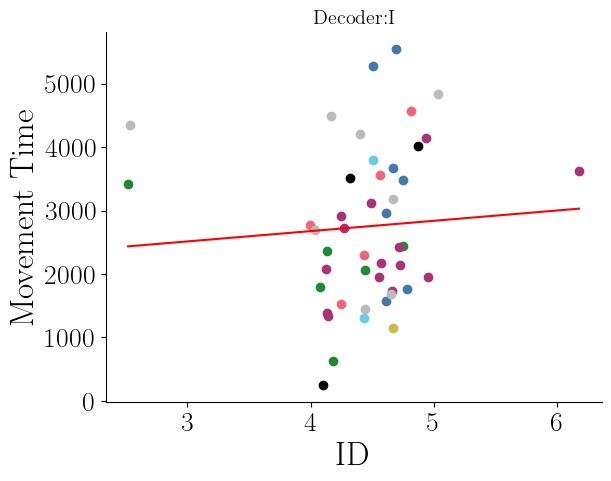

Slope: 522.8527026197022
Intercept: -177.1676358126274


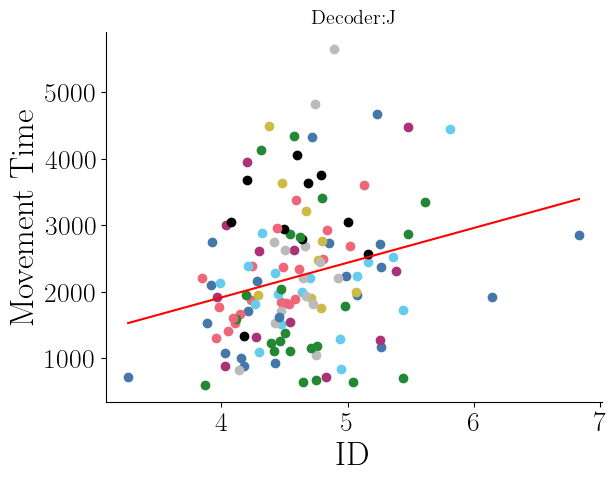

Slope: 402.87131658263206
Intercept: 1422.3223687390673


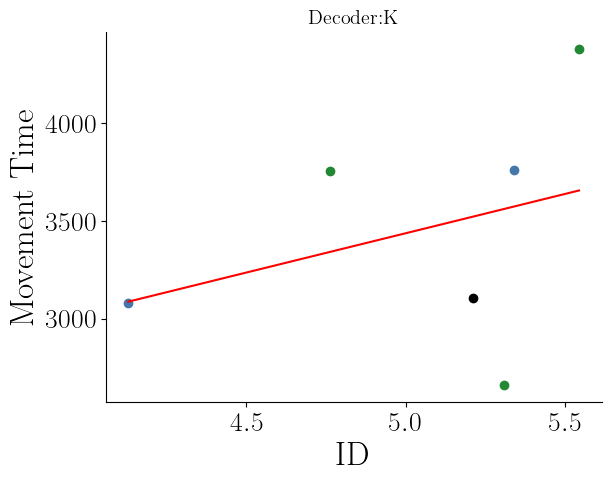

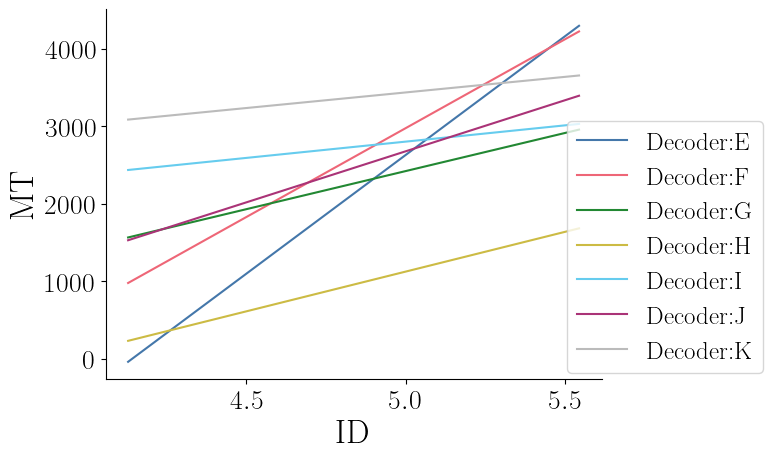

In [45]:
# Plot a scatter plot

from sklearn.linear_model import LinearRegression

decoderLinearLines = np.zeros((noDecoders,100))

for j in range(7):
    xPoints,yPoints = [],[]
    for i in range(11):
        xPoints.extend(IDsAll[j][i])
        yPoints.extend(MTsAll[j][i])

        plt.scatter(IDsAll[j][i],MTsAll[j][i], color = cmap[i%len(cmap)])
    ax = plt.gca()
    plt.title("Decoder:" +decoderNum2Letter[j])
    pf.defaultPlottingConfiguration(ax,xlabel = "ID", ylabel ="Movement Time" )

    model = LinearRegression()

    x = np.asarray(xPoints).reshape(-1,1)
    y = np.asarray(yPoints)

    # Fit the model
    model.fit(x,y)

    # Get the slope (coefficient) and intercept of the line
    slope = model.coef_[0]
    intercept = model.intercept_

    # Print the slope and intercept
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")

    # Generate points on the regression line
    x_line = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    
    y_line = model.predict(x_line)

    decoderLinearLines[j,:] = y_line

    plt.plot(x_line, y_line, color='red', label='Regression line')

    # plt.yscale('log')
    # plt.xscale('log')
    
    plt.show()

# Plot all lines on top
for i in range(noDecoders):
    plt.plot(x_line, decoderLinearLines[i,:], color=cmap[i], label="Decoder:" + decoderNum2Letter[i])

plt.legend()
ax = plt.gca()
plt.legend()
pf.defaultPlottingConfiguration(ax,xlabel="ID",ylabel = 'MT')
plt.legend(loc = 'upper right', fontsize = 18,bbox_to_anchor=(1.35, 0.73))


In [46]:
MTsAll[4][0]

[5550.0, 3673.0, 2959.0, 3484.0, 1770.0, 5273.0, 1580.0]